# Travelling salesman problem

Specifications of the problem : [https://en.wikipedia.org/wiki/Travelling_salesman_problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

## Librairies

Here's all the libraries needed.

In [ ]:
from itertools import combinations, accumulate
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm.auto import tqdm

## Initialization

We extract the cities from the file and create a matrix to store the distance between each city.

In [161]:
FILE = 'cities/china.csv' # Modify this path to select the problem

MAX_STEPS = 500_000

CITIES = pd.read_csv(FILE, header=None, names=['name', 'lat', 'lon'])

SIZE = len(CITIES)

DIST_MATRIX = np.zeros((SIZE, SIZE))

# Compute the matrix of distances in km
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

Let's also define the cost of a solution by computing the total distance.

In [162]:
def cost(tsp: list) -> int:
    """Return the cost of a tsp solution"""
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]

    return tot_cost

Finally, we define a function that will ensure that the solution is indeed a Hamiltonian cycle by checking that :
- It's a cycle
- It visit each vertex exactly once

In [163]:
def valid(tsp: list) -> bool:
    """Return true if the given tsp is valid"""

    # Check if the solution is a cycle
    if tsp[0] != tsp[SIZE]:
        return False

    # Check that the vertex is visited once
    already_visited = list()
    for i in range(SIZE):
        city = tsp[i]

        if city in already_visited:
            return False

        already_visited.append(city)

    # Check that all vertex is visited
    if len(already_visited) != SIZE:
        return False

    return True

## First greedy algorithm

At first, I just wanted a working solution in order to upgrade it step by step. 

So I define a fist greedy function that solves a tsp by going always the closest city.

In [164]:
def greedy_tsp(dist_matrix) -> list :
    """Function that solves a tsp problem on a given matrix of distances using a greedy approach"""
    dist = dist_matrix.copy()
    city = 0
    tsp = list()

    while not np.all(dist == np.inf):
        tsp.append(city)
        dist[:, city] = np.inf # don't select this city anymore
        closest = np.argmin(dist[city]) # select the closest city
        city = closest
    
    tsp.append(tsp[0]) # Add the first city and close the hamiltonian cycle
    return tsp

Let's see what it does.

In [165]:
tsp = greedy_tsp(DIST_MATRIX)

print(f"The solution is {'not ' if not valid(tsp) else ''}valid, total cost : {cost(tsp=tsp)}")
    

The solution is valid, total cost : 63962.91842945519


As we can see, this is pretty fast, indeed the temporal complexity of the algorithm is pretty much in $O(N^2)$, where N is the number of cities.

It has also a good result, not the best one because the algorithm doesn't care about the last path.

## First Hill climbing

Let's try to achieve a better result by using hill climbing.

It's important to note that in my hill climbing algorithms, I select a random city as my first and final step.

When performing mutations, I never touch them. It's simpler in order to always have a cycle. Remember that **len(solution) = SIZE + 1**


Let's first define the fitness to be the opposite of the cost, in order to have a gradient ascent.

In [166]:
def fitness(tsp: list) -> int:
    return -cost(tsp)

We can then define our first tweak function that will simply swap two points in a given path.

In [167]:
def swap(tsp: list) -> list:
    """Perform a random swap between two element in a list"""
    # Select two random indexes
    first_index = np.random.randint(1, SIZE) # Never update the first and last element to keep the cycle
    second_index = np.random.randint(1, SIZE)

    # Swap elements
    tmp = tsp[first_index]
    tsp[first_index] = tsp[second_index]
    tsp[second_index] = tmp
    
    return tsp

def swap_mutation(tsp: list) -> list:
    """Tweak function that will perform a swap between two elements in the tsp"""
    new_tsp = tsp.copy()

    swap(new_tsp)

    return new_tsp

Finally, we can define our hill climbing. It will use the simplest mutation for **fixed-length integer array of one-time items** representation, which is swap mutation.

In [168]:
def swap_mutation_hill_climbing_tsp() -> tuple[list, list[int]]:
    """Returns a solution of a tsp by using hill climbing with swap mutation"""
    # Create a first random solution
    solution = list(range(SIZE))
    np.random.shuffle(solution)
    solution.append(solution[0]) # Add the first city and close the hamiltonian cycle

    fitness_solution = fitness(solution) 
    history = [fitness_solution]

    for _ in range(MAX_STEPS):
        # Tweak the current solution
        test_solution = swap_mutation(solution)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution)

        # Select the new solution if it's better
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution


    return solution, history

Let's run it and see if it improve.

The solution is valid, total cost : 184875.68957311925


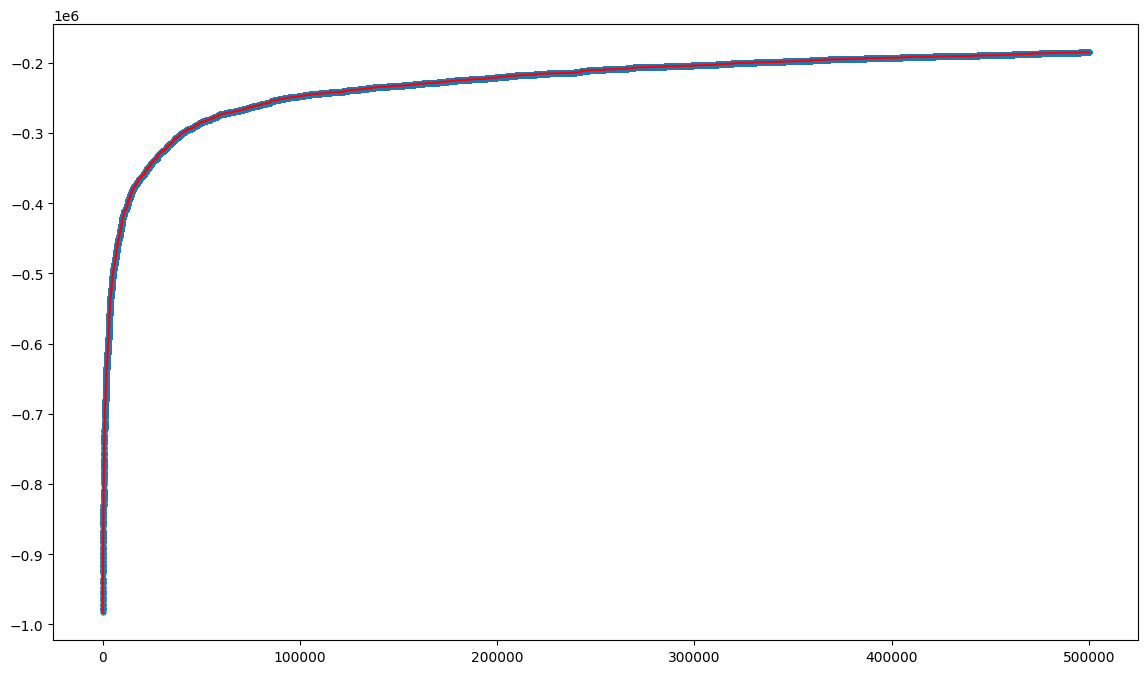

In [183]:
# Perform algorithm
tsp, history = swap_mutation_hill_climbing_tsp()

# Show results
print(f"The solution is {'not ' if not valid(tsp) else ''}valid, total cost : {cost(tsp=tsp)}")

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

This is more than two times worse than the greedy one, but it is still a great starting point for our hill climbing algorithm, let's try to improve it.

## Scramble Mutation

Let's add a way to balance exploration and exploitation by having a kind of strength in the tweak function.

We can use **Scramble Mutation** and use the number of selected alleles to have this strength.

In this way, we can perform exploration at the beginning, and then focus more on exploitation of a solution.

In [180]:
def scramble_mutation(tsp: list, n: int) -> list:
    """Tweak function that will select strength random indexes and shuffle them"""
    new_tsp = tsp.copy()

    # Just perform a swap if n is one or less
    if n <= 1:
        return swap(new_tsp)

    # Check boundaries
    if n > SIZE:
        n = SIZE

    # Select n unique indexes
    indexes = set(np.random.randint(1, SIZE, size=n))
    
    # Get the values of thoses selected indexes
    values_to_scramble = [new_tsp[i] for i in indexes]

    np.random.shuffle(values_to_scramble)

    # Replace them in the solution
    for i, scrambled_value in zip(indexes, values_to_scramble):
        new_tsp[i] = scrambled_value

    return new_tsp

Let's also define a new hill climbing algorithm to use it. It will use the 1/5 success rule :
- If we have more than one success over 5 -> increase the number of scramble
- If we have less than one success over 5 -> decrease the number of scramble

In [181]:
def scramble_mutation_hill_climbing_tsp() -> tuple[list, list[int]]:
    """Returns a solution of a tsp by using hill climbing with dynamic scramble mutation"""
    # Create a first random solution
    solution = list(range(SIZE))
    np.random.shuffle(solution)
    solution.append(solution[0]) # Add the first city and close the hamiltonian cycle

    fitness_solution = fitness(solution)
    history = [fitness_solution]

    # Initialization of the success rule
    n = int(SIZE/8)
    success = 0

    for i in range(MAX_STEPS):
        # Every five iterations if we have more than one success increase n else if we have less than one, decrease it
        if i%5:
            if success > 1:
                n += 1
            elif success < 1 and n > 1:
                n -= 1
            success = 0

        # Tweak the current solution
        test_solution = scramble_mutation(solution, n)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution)

        # Select the new solution if it's better
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution
            success += 1

    return solution, history

Let's see what it can do.

The solution is valid, total cost : 182934.36734181206


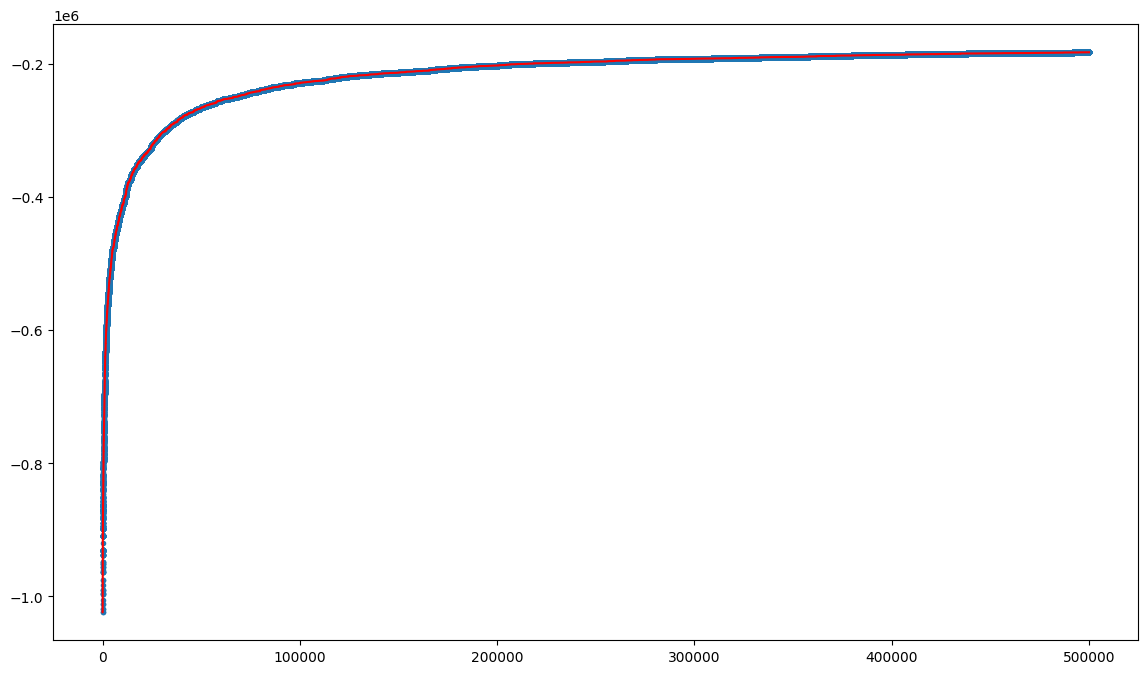

In [184]:
# Perform algorithm
tsp, history = scramble_mutation_hill_climbing_tsp()

# Show results
print(f"The solution is {'not ' if not valid(tsp) else ''}valid, total cost : {cost(tsp=tsp)}")

# Graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

This new version is a bit better, we have more exploration at the begining, and more exploitation at the end.

But the issue is that we are only looking for one local optimum even if it's a bad one.

## Evolutionary Algorithm

We can try implementing evolutionary algorithm to be able to explore, compare and merge multiple local optimums in order to try reaching for the global one.

![Evolutionary Algorithm schema](./assets/EA_schema.png)

Let's first define the structure of one individual in our population.

It will contain the genome (current solution of the tsp) and also its fitness.

In [173]:
@dataclass
class Individual:
    genome: list[int]
    fitness: float = None

Let's define a parent selection function.

For this part, let's implement the tournament selection, we pick n random members from the population and select the best out of these.

In [ ]:
def tournament_selection(population: list[Individual], n: int) -> Individual:
    """Perform a tournament selection, picking n random fighters from a given population and return the best one"""
    # Pick random fighters
    tournament = np.random.randint(0, len(population), size=n)
    fighters: list[Individual] = [population[i] for i in tournament]

    # Select the best one
    winner = fighters[0]
    for fighter in fighters[1:]:
        if fighter.fitness > winner.fitness:
            winner = fighter

    return winner

Next, we need to define a crossover function.

We will take over Inver, which will allow us to preserve locality in our solutions (locality is probably a good trait for TSP).

In [175]:
def inver_over_crossover(p1: Individual, p2: Individual) -> Individual:
    """Perform inver over crossover between to given parents and return the child"""
    genome = p1.genome.copy()

    # Select one city in the first parent
    starting_city = p1.genome[np.random.randint(1, SIZE)]

    # Select the closest city of the starting_city
    next_city = p2.genome[(p2.genome.index(starting_city) + 1) % len(p2.genome)]

    # Reverse the order
    if next_city != genome[0]: # Ensure that we don't break the cycle
        idx1, idx2 = genome.index(starting_city), genome.index(next_city)
        if idx1 > idx2:
            idx1, idx2 = idx2, idx1
        genome[idx1+1:idx2+1] = reversed(genome[idx1+1:idx2+1])

    return Individual(genome, fitness(genome))

We also need a mutation function.

Let's just adapt the last mutation we write for hill climbing, scramble mutation.

In [176]:
def scramble_mutation(tsp: Individual, n: int) -> Individual:
    """Tweak function that will select strength random indexes and shuffle them"""
    genome = tsp.genome.copy()

    # Just perform a swap if n is one or less
    if n <= 1:
        return Individual(swap(genome), fitness(genome))

    # Check boundaries
    if n > SIZE:
        n = SIZE

    # Select n unique indexes
    indexes = set(np.random.randint(1, SIZE, size=n))
    
    # Get the values of thoses selected indexes
    values_to_scramble = [genome[i] for i in indexes]

    np.random.shuffle(values_to_scramble)

    # Replace them in the solution
    for i, scrambled_value in zip(indexes, values_to_scramble):
        genome[i] = scrambled_value

    return Individual(genome, fitness(genome))

Finally let's define the behavior of our evolutionary algorithm.

We will use a steady state approach since the children will compete against parents to survive.

In [177]:
# Constants
POPULATION_SIZE=20
OFFSPRING_SIZE=10
MAX_GENERATIONS=500_000

def init_individual() -> Individual:
    """Return a purely random individual for the TSP problem"""
    genome = list(range(SIZE))
    np.random.shuffle(genome)
    genome.append(genome[0]) # Add the first city and close the hamiltonian cycle
    return Individual(genome, fitness(genome))

def ea_tsp() -> tuple[Individual, list[float]]:
    """Function that performs the evolutionary algorithm"""
    # Initialization of the population
    population = [init_individual() for _ in range(POPULATION_SIZE)]
    history = [population[0].fitness]

    # Constants for the 1/5 success rule
    n = 8
    i = 0
    success = 0
    
    # Generations
    for _ in tqdm(range(MAX_GENERATIONS)):
        offspring: list[Individual] = list()
        
        # Generate offspring
        for _ in range(OFFSPRING_SIZE):
            if np.random.random() < .5:
                # 1/5 success rule
                if i == 5:
                    if success > 1:
                        n += 1
                    elif success < 1 and n > 1:
                        n -= 1
                    success = 0
                    i = 0

                # perform mutation of one parent
                parent = tournament_selection(population, int(OFFSPRING_SIZE/3))
                new_individual = scramble_mutation(parent, n)
                i+= 1

                # 1/5 success rule
                if new_individual.fitness > parent.fitness:
                    success += 1
            else:
                # Take two parents and perform crossover
                parent1 = tournament_selection(population, int(OFFSPRING_SIZE/3))
                parent2 = tournament_selection(population, int(OFFSPRING_SIZE/3))
                new_individual = inver_over_crossover(parent1, parent2)

            offspring.append(new_individual)

        # Steady state -> add offspring to population and perform the survivor selection
        population.extend(offspring)
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:POPULATION_SIZE]

        history.append(population[0].fitness)

    return population[0], history

Let's run it and see the results.

100%|██████████| 500000/500000 [09:12<00:00, 905.28it/s] 


The solution is valid, total cost : 131937.17379219198


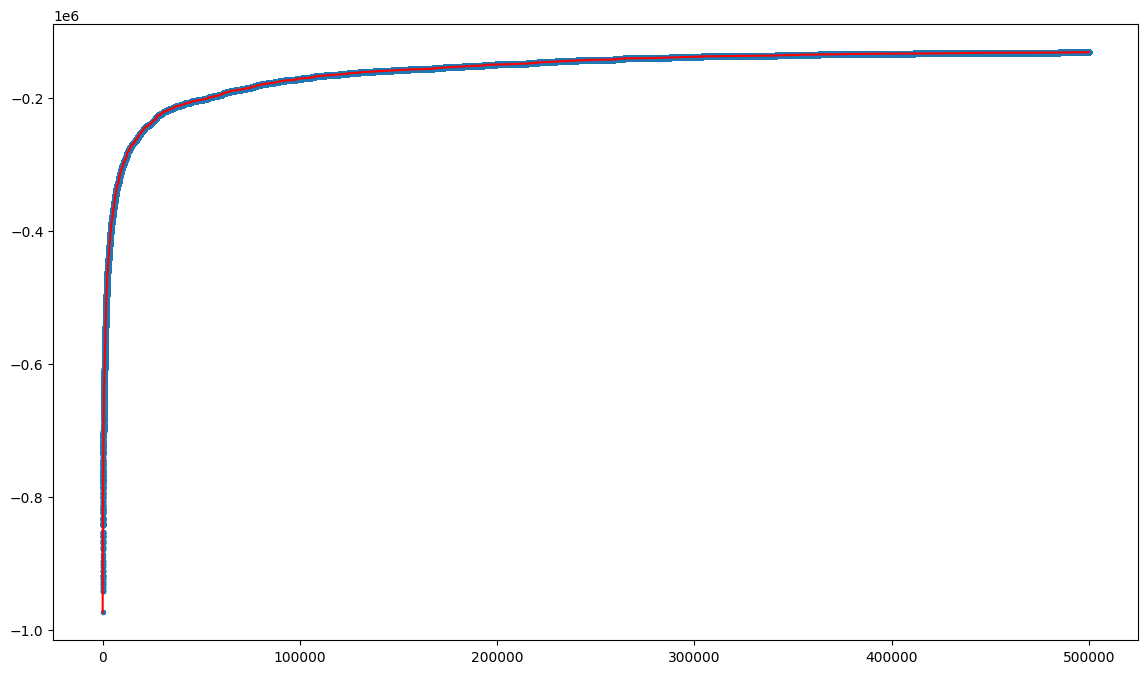

In [178]:
# Perform algorightm
tsp, history = ea_tsp()

# Results
print(f"The solution is {'not ' if not valid(tsp.genome) else ''}valid, total cost : {cost(tsp=tsp.genome)}")

# Show graph
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

As we can see it's better, but we are still worse than the greedy algorithm in terms of comparison and results.

Some ways of improvement could be to run the algorithm longer, tweak some hyperparameters or choosing others genetic operator.